# Simple ARIMA model for non-seasonal time-serie forecast

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data
Let's start by loading the time series of the challenge

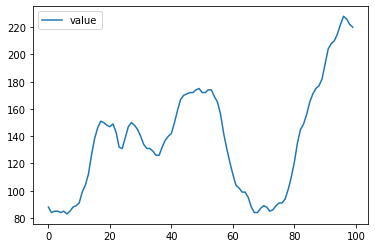

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('data/wwwusage.csv', names=['value'], header=0)
y = df.value
df.plot();

This abstract time serie does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regresive Moving Average (ARIMA) models


## 2. Build ARIMA model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time serie (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the Moving-Average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure stationarity

ARIMA models applies to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [2]:
# YOUR CODE HERE
from statsmodels.tsa.stattools import adfuller

adfuller(y)[1]

0.12441935447109487

The p-value should be  less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat process on the differentiated serie if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationnary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

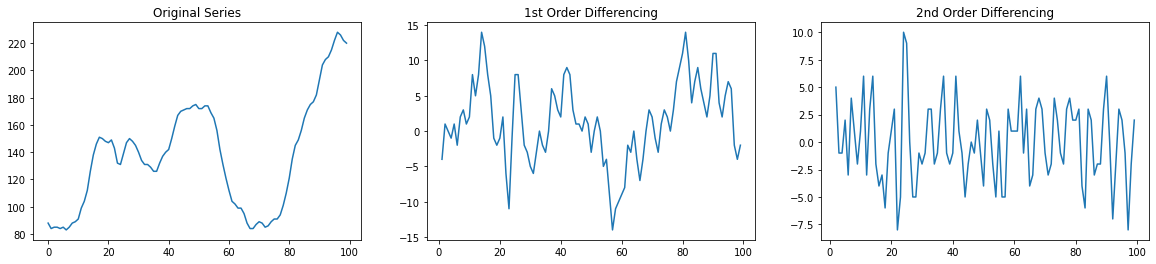

In [3]:
# YOUR CODE HERE
import pandas as pd
zero_diff = df.value
first_order_diff = df.value.diff(1)
second_order_diff = df.value.diff(1).diff(1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing');

We have a close-call here between one and two diff orders. Differentiating too much a time series may also reduce performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

In [4]:
first_order_diff

0     NaN
1    -4.0
2     1.0
3     0.0
4    -1.0
     ... 
95    7.0
96    6.0
97   -2.0
98   -4.0
99   -2.0
Name: value, Length: 100, dtype: float64

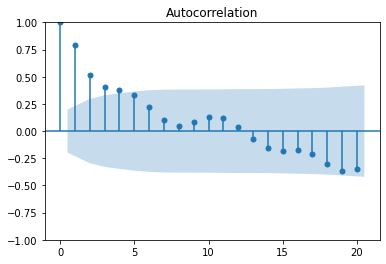

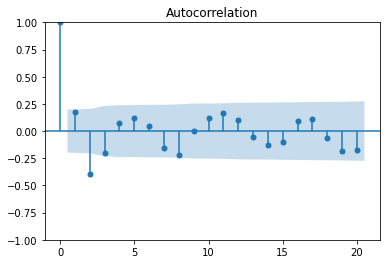

In [5]:
# YOUR CODE HERE
from statsmodels.graphics.tsaplots import plot_acf


plot_acf(first_order_diff.dropna())
plot_acf(second_order_diff.dropna())
plt.show()

In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (temptatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

In [6]:
y_diff = y.diff().dropna()

We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary (I refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

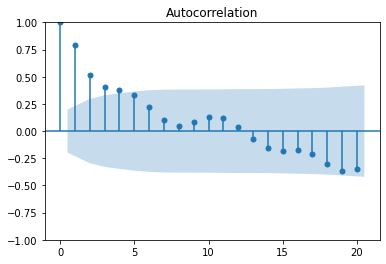

In [8]:
# YOUR CODE HERE
plot_acf(y_diff)
plt.show()

We could choose q = 4, but it's more conservatively to try with `q=2` to start with.

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

/home/bitazaratustra/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


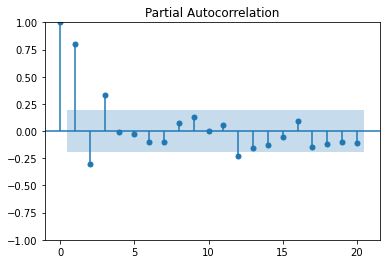

In [9]:
# YOUR CODE HERE
plot_pacf(y_diff)
plt.show()

We could choose `p = 3` as the first 3 lag terms seems above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d` and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the the model
- print the model (`.summary`)

In [10]:
# YOUR CODE HERE
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(df['value'], order=(1, 1, 2), trend='t')
arima = arima.fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -253.790
Date:                Thu, 01 Sep 2022   AIC                            517.580
Time:                        18:03:50   BIC                            530.556
Sample:                             0   HQIC                           522.830
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1199      1.324      0.846      0.398      -1.476       3.716
ar.L1          0.6352      0.144      4.406      0.000       0.353       0.918
ma.L1          0.5285      0.179      2.959      0.003       0.178       0.878
ma.L2         -0.0012      0.168     -0.007      0.994      -0.331       0.328
sigma2         9.7262      1.407      6.913      0.000       6.969      12.484
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.94   Prob(JB):                         0.94
Heteroskedasticity (H):               0.60   Skew:                            -0.08
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
arima2 = ARIMA(df['value'], order=(1, 1, 1), trend='t')
arima2 = arima2.fit()
arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Date:                Thu, 01 Sep 2022   AIC                            515.580
Time:                        18:03:50   BIC                            525.961
Sample:                             0   HQIC                           519.780
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1203      1.322      0.848      0.397      -1.470       3.711
ar.L1          0.6344      0.091      6.950      0.000       0.455       0.813
ma.L1          0.5297      0.090      5.907      0.000       0.354       0.705
sigma2         9.7260      1.402      6.937      0.000       6.978      12.474
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.94   Prob(JB):                         0.94
Heteroskedasticity (H):               0.60   Skew:                            -0.08
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

☝️ If your p-values are too high, try remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate overall performance of your fit by minimizing the [`AIC - akaike information criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remains low) and maintain a quasi similar AIC score than other models

## 3. Evaluate model performance

👉 Visualize your model predictions with the `plot_predict()` method

- Look closely at the method default params, especially `dynamic`. 
- Do you think your model would have such good performance in reality?

In [12]:
from statsmodels.graphics.tsaplots import plot_predict

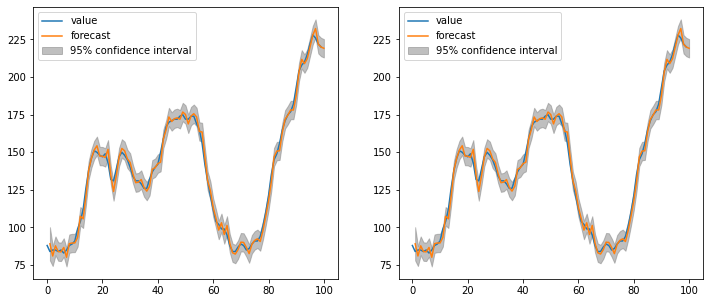

In [13]:
# YOUR CODE HERE
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(df['value'], label='value')
axs[1].plot(df['value'], label='value')

plot_predict(arima2, start=1, end=100, ax=axs[0]);
plot_predict(arima, start=1, end=100, ax=axs[1]);

☝️ `dynamic=False` actually makes use of all available values `y` in order to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prection of the _last 15 values_ in a situation where the model only have _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ it's previouly predicted value for 86
- etc...iteratively until 100

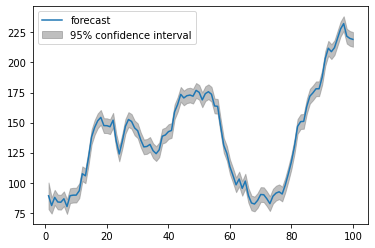

In [14]:
# YOUR CODE HERE
plot_predict(arima2, start=1, end=100);

☝️ That's still not a _true_ forecast!! Why??

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` serie during the fitting phase!
</details>

### 3.1 Out-of-sample forecasts (real "future")

👉 Create a train-test-split keep the last 15 datapoints only for the test set, and train your ARIMA on the train set only.

In [15]:
# YOUR CODE HERE
train = df.value[:85]
test = df.value[85:]

arima_final = ARIMA(train, order=(1, 1, 1), trend='t')  
arima_final = arima_final.fit()

forecast = arima_final.forecast(len(test), alpha=0.05)
forecast_results = arima_final.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

👉 We are "now" in step 85 and have never seen the future:
- Use the `get_forecast()` method on your fitted `arima` model to "forecast" the 15 next datapoints (i.e beyond the end of your train dataset) 

This returns a `PredictionResultsWrapper` object from `statsmodels`, store it in a variable `forecast_results`  

It is hard to navigate at first, here are some tips:
- You can find your forecasts in: `forecast_results.predicted_mean`
- Your confidence intervals are given by `forecast_results.conf_int()`

In [16]:
# YOUR CODE HERE
forecast_results.predicted_mean


85    163.325309
86    168.399976
87    172.005469
88    174.651917
89    176.672319
90    178.284052
91    179.629014
92    180.799833
93    181.856976
94    182.839912
95    183.774409
96    184.677285
97    185.559520
98    186.428281
99    187.288246
Name: predicted_mean, dtype: float64

In [17]:
forecast_results.conf_int()

,lower value,upper value
85,157.105317,169.545301
86,153.705131,183.094821
87,148.812206,195.198732
88,143.386403,205.917431
89,137.893817,215.450821
90,132.559156,224.008947
91,127.482980,231.775047
92,122.701026,238.898640
93,118.215645,245.498306
94,114.012796,251.667028


👉 Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

👉 Try to also plot your previous 85 `y` real datapoints to better grasp model performance relative to the past

In [18]:
# YOUR CODE HERE
import numpy as np

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

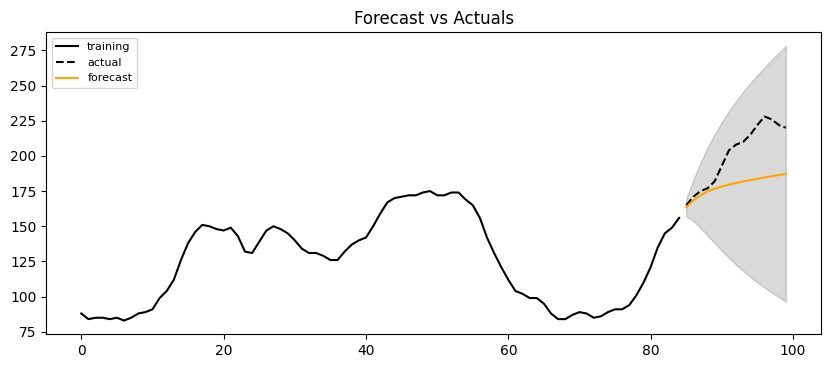

In [82]:
plot_forecast(forecast, train, test, confidence_int[:,0], confidence_int[:,1])

### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals if you really want)

Note: residuals are constructed by 'seing' all data as in `plot_predict(dynamic=False)`

Also try to plot a histogram or kde fit of the residuals to see if they are approximately normally distributed.

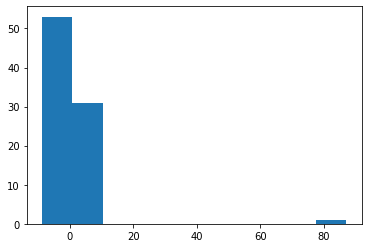

In [29]:
# YOUR CODE HERE
plt.hist(arima_final.resid); ax1.set_title("Model Residuals")
plt.show()

## 3.3 Cross-validated performance metrics

👉 Below are the given the most common performance metrics for time series

In [ ]:
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [35]:
import pmdarima as pm
smodel = pm.auto_arima(df.values,
                       start_p=1, max_p=2,
                       start_q=1, max_q=3,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=560.984, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1120.551, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=528.581, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=543.538, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=530.615, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=532.889, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=528.581, Time=0.22 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 1.045 seconds


👉 Play with you ARIMA hyper-parameters and see the impact on your forecast performance

In [ ]:
# YOUR CODE HERE

## 4 Grid Search

Try to run your own gridsearch for (p,d,q) using `pmdarima`. Use at least
- `test='adf'`
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [31]:
import pmdarima as pm

model = pm.auto_arima(train, 
                      start_p=0, max_p=3,
                      start_q=0, max_q=3, 
                      d=None,           # let model determine 'd'
                      test='adf',       # using adftest to find optimal 'd'
                      trace=True, error_action='ignore',  suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=449.662, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=449.569, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=445.819, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=445.820, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=441.300, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=438.613, Time=0.05 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=440.036, Time=0.10 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=440.231, Time=0.09 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 0.639 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(0, 2, 3)   Log Likelihood                -215.307
Date:                Thu, 01 Sep 2022   AIC                   

## (Optional) Cross-validate performance of your model?

In practice, Results and GridSearch should always be cross validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create continguous K-folds so as to truly evaluate the performance of your model and find the best hyper-params after cross validation

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png'>

**ARIMA - Cross-Validation using TimeSeriesSplit + Grid Search**

In [37]:
# YOUR CODE HERE
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

initial = f'{5 * 365} days' # needs to be in exactly this format
period = f'{5 * 365} days'
horizon = '365 days'
df_cv = cross_validation(arima_final, initial=initial, period=period, horizon=horizon)

ModuleNotFoundError: No module named 'fbprophet'

In [41]:
Best_model = ARIMA(order= (0,2,3), seasonal_order= (0,0,0,0)) 

TypeError: __init__() missing 1 required positional argument: 'endog'

In [38]:
df.sort_values('AIC').groupby('(p,d,q)').mean()['AIC'].sort_values()

KeyError: 'AIC'

☝️ Our initial choice of model (1, 1, 2) is not so bad!
Notice that the dataset (100 datapoints) is in reality way to small to cross-val anything!